In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
import sklearn.metrics as metrics
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime


In [11]:
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y')

df1 = pd.read_csv("data/data_set_1.csv", parse_dates=[1], date_parser=dateparse, encoding='utf-8')
df2 = pd.read_csv("data/data_set_2.csv", parse_dates=[1], date_parser=dateparse, encoding='utf-8')
df = pd.concat([df1,df2]).reset_index(drop=True)
product_list = df['product'].unique()
len(product_list)

2432

In [12]:
df_preprocessed = pd.DataFrame(columns=["Product","quantity"])
my_dict = {}
window_size = 6
inputs = ["x"+str(x) for x in np.arange(1,window_size+1)]
col = np.concatenate([['Product'],inputs,['y']])
print(col)
df_preprocessed = pd.DataFrame(columns=col)
my_dict = {}

['Product' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'y']


In [5]:
count = 0
i=0
while(i<10): 
    df_prod = df.loc[df['product'] == product_list[i]]
    df_prod_month = df_prod.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    # print(len(df_prod_month))
    if len(df_prod_month)>=130:
        df1 = df_prod_month
        values = df1["quantity"].values
        local = pd.DataFrame(columns=["Product"])
        for j in range(window_size):
            local[col1[j]] = values[j:len(values)-window_size+j-1]

        local['y'] = values[window_size:len(values)-window_size+window_size-1]
        local['Product'] = i
        my_dict[part] = i
        i+=1
        df_preprocessed = pd.concat([df_preprocessed, local], axis = 0, sort = False,ignore_index=True)
        count+=1

df_preprocessed

,Product,x1,x2,x3,x4,x5,x6,y
0,0,20,18,31,25,29,35,206
1,0,18,31,25,29,35,206,110
2,0,31,25,29,35,206,110,147
3,0,25,29,35,206,110,147,133
4,0,29,35,206,110,147,133,121
...,...,...,...,...,...,...,...,...
23911,191,0,1,0,0,0,0,0
23912,191,1,0,0,0,0,0,0
23913,191,0,0,0,0,0,0,0
23914,191,0,0,0,0,0,0,0


In [6]:
df_preprocessed.to_csv("preprocessed.csv")
data = df_preprocessed.sample(frac = 1)
data.shape

(23916, 8)

In [8]:
#data = data.astype(float)
#data

In [7]:
input_col = data.columns[:-1]
output_col = data.columns[-1:]
x = data[input_col].values.astype(int)
y = data[output_col].values.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17937, 7)
(5979, 7)
(17937, 1)
(5979, 1)


In [8]:
def lstm():
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(64),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 50))
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss="mean_squared_error",
                   #loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mse"])
    model.summary()
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test,y_test), callbacks=[lr_schedule])
    return history,model

In [11]:
def cnn_lstm():
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 200)
    ])
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 50))
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set, epochs=5, callbacks=[lr_schedule])
    return history,model

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
batch_size = 32
shuffle_buffer_size = 10
#x_train = x_train.reshape((x_train.shape[0], 1, 1, 1, window_size+1))
#x_test = x_test.reshape((x_test.shape[0], 1, 1, 1, window_size+1))

In [9]:
history,model = lstm()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0

In [16]:
#model.save("Multivariate.h5")

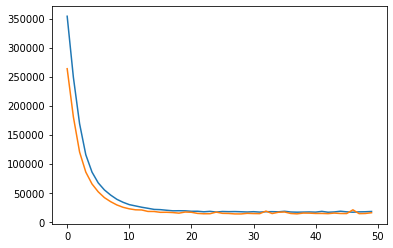

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.axis([0,500,0,0.005])
plt.show()

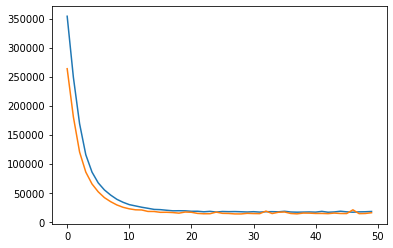

In [18]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
#plt.axis([0,500,0,0.01])
plt.show()

In [19]:
y_pred = model.predict(x_train)
train_rmse = (metrics.mean_squared_error(y_train, y_pred))
print("Training RMSE: ",train_rmse)

from sklearn.metrics import r2_score
print(r2_score(y_train, y_pred))

y_pred = model.predict(x_test)
test_rmse = (metrics.mean_squared_error(y_test, y_pred))
print("Testing RMSE: ",test_rmse)

from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

Training RMSE:  16420.89221108305
0.9494740699066556
Testing RMSE:  15464.409249654786
0.9472417922946522


In [20]:
#model.score(y_test, y_pred)

In [21]:
# for i in range(len(y_test)):
    # print(y_test[i][0],"-->",int(y_pred[i][0]))

61 --> -3
0 --> -42
241 --> 218
620 --> 768
370 --> 361
270 --> 167
15 --> -5
58 --> 14
1 --> -29
620 --> 580
110 --> 108
70 --> 40
261 --> 380
0 --> -33
56 --> 5
10 --> 28
3 --> -44
135 --> 137
150 --> 115
117 --> 33
1 --> -44
60 --> 69
979 --> 1003
2262 --> 2922
35 --> 9
0 --> -18
437 --> 432
1452 --> 1096
160 --> 212
10 --> -3
80 --> 24
5 --> -25
48 --> 32
36 --> 13
121 --> 127
14 --> -19
17 --> 6
126 --> 118
320 --> 172
240 --> 200
25 --> -4
1 --> -30
80 --> 129
2578 --> 2931
1 --> -43
391 --> 402
20 --> 38
2088 --> 2745
157 --> 169
0 --> -7
1009 --> 1105
42 --> 19
26 --> 5
112 --> 36
0 --> -37
5 --> -19
343 --> 422
40 --> 14
612 --> 642
15 --> -6
1150 --> 1065
23 --> 14
29 --> -2
5 --> -25
23 --> 11
34 --> 82
1161 --> 1128
0 --> -35
290 --> 235
30 --> 62
1144 --> 878
2967 --> 3612
56 --> 41
21 --> 68
33 --> 14
10 --> -4
270 --> 198
6 --> -15
359 --> 282
844 --> 1030
1 --> -35
0 --> -4
5 --> 16
6 --> -19
92 --> 52
370 --> 351
1 --> -37
280 --> 245
80 --> 22
33 --> 84
63 --> 94
40 -

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9512694402286569

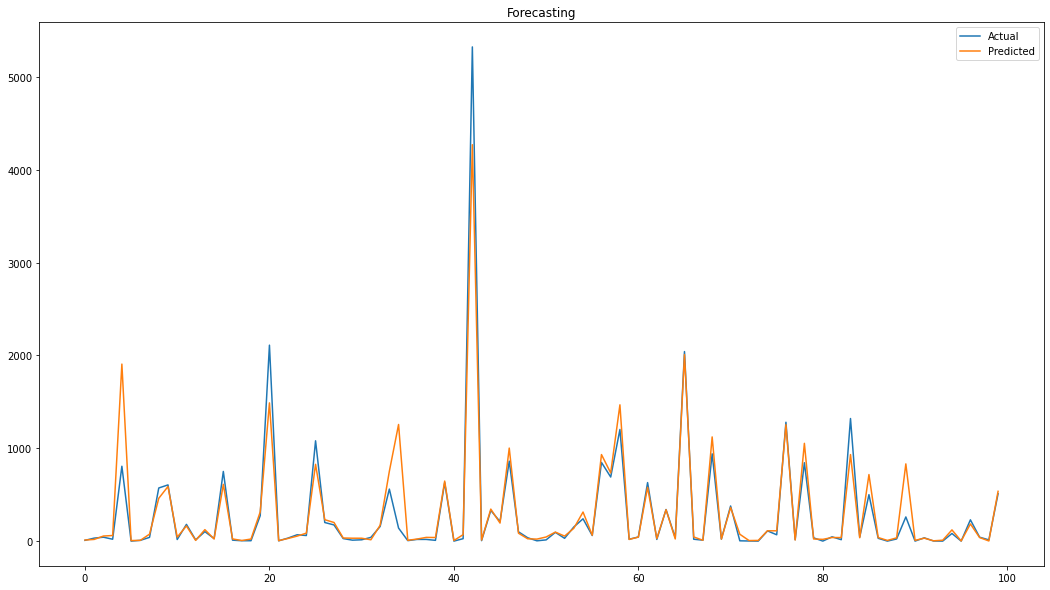

In [ ]:
y_pred= model.predict(x)
plt.figure(figsize=(18, 10))
plt.plot(y[0:100])
plt.plot(y_pred[0:100])
plt.title("Forecasting")
plt.legend(["Actual", "Predicted"], loc ="upper right")